This notebook performs the following validations on the forecasting models:
1. Calibration
2. Comparison Harvey vs logistic
3. Comparison independant vs joint model

# Imports and load dataset

In [1]:
import pandas as pd
import arviz as az
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import energy_distance
from typing import Literal

/Users/antoinemaier/Documents/Semaphore/benchmark-forecasting/.venv/lib/python3.14/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
dataset = (
    pd.read_csv("benchmark_data_processed/all_normalized_updated_benchmarks.csv")
    .astype(
        {
            "benchmark": "string",
            "release_date": "datetime64[ns]",
            "score": "float64",
            "lower_bound": "float64",
        }
    )
    .dropna(subset=["benchmark", "release_date", "score", "lower_bound"])
)

# Tools

## Modelling

In [ ]:
def get_frontier(df: pd.DataFrame, top_n: int = 1) -> pd.DataFrame:
    """Filter the dataset to include only the top_n frontier scores for each benchmark.

    Args:
        df: A dataset with columns "benchmark", "release_date", and "score".
        top_n: Number of top scores to consider when filtering the dataset.
    Returns:
        A filtered dataset containing only the top_n frontier scores for each benchmark.
    """
    return (
        df.sort_values(["benchmark", "release_date"])
        .assign(
            expanding_rank=lambda df: df.groupby("benchmark")["score"]
            .expanding()
            .rank(ascending=False, method="max")
            .reset_index(level=0, drop=True)
        )
        .loc[lambda df: df["expanding_rank"] <= top_n]
        .drop(columns=["expanding_rank"])
        .reset_index(drop=True)
    )


def format_dataset_for_modeling(
    dataset: pd.DataFrame,
    top_n: int = 3,
) -> pd.DataFrame:
    """Prepare the dataset for modeling by filtering to the top_n frontier scores and adding necessary columns.

    Args:
        dataset: A dataset containing benchmark data.
        top_n: Number of top scores to consider when fitting the model.
    Returns:
        A formatted dataset ready for modeling.
    """
    dataset = get_frontier(dataset, top_n=top_n)
    dataset = dataset.assign(
        days=lambda df: (
            df["release_date"]
            - df.groupby("benchmark")["release_date"].transform("min")
        ).dt.days
    ).assign(
        # Midpoint of the time range in days is simple the max divided by two since min is zero
        days_mid=lambda df: (df.groupby("benchmark")["days"].transform("max") / 2.0)
    )
    return dataset


def fit_model(
    dataset: pd.DataFrame,
    sigmoid_kind: Literal["logistic", "harvey"] = "logistic",
    joint: bool = True,
    top_n: int = 3,
    n_samples: int = 2000,
    n_tune: int = 1000,
    progressbar: bool = True,
) -> tuple[az.InferenceData, pm.Model]:
    """Fit a Bayesian model to the dataset using the specified sigmoid function.

    If the dataset contains more than one benchmark, a joint model with shared hyperparameters is fitted.

    This allows benchmarks to inform each other through common priors on:
    - L_mu, L_sigma: (upper) asymptote distribution parameters
    - k_mu, k_sigma: growth rate distribution parameters
    - xi_base_mu, xi_base_sigma: noise level distribution parameters
    - s_mu, s_sigma: skewness distribution parameters

    Args:
        dataset: A dataset containing benchmark data. It must be formatted by `format_dataset_for_modeling` first.
        sigmoid_kind: Type of sigmoid function to model the latent mean performance growth ('logistic' or 'harvey').
        joint: Whether to fit a joint model with shared hyperparameters across benchmarks.
        top_n: Number of top scores to consider when fitting the model. If top_n=1, only the frontier scores are used.
        n_samples: Number of MCMC samples to draw from the posterior distribution.
        n_tune: Number of tuning steps for the MCMC sampler.
        progressbar: Whether to display a progress bar during sampling.

    Returns:
        A tuple containing an arviz InferenceData object with the posterior samples and the pymc Model object.
    """
    benchmark_idx, benchmark_names = pd.factorize(dataset["benchmark"], sort=True)
    dataset["benchmark_idx"] = benchmark_idx
    coords = {
        "benchmark": benchmark_names,
        "obs": dataset.index,
    }

    with pm.Model(coords=coords) as model:
        # Upper asymptote
        L_min = 0.75
        L_max = 1.0
        L_range = L_max - L_min
        if joint:
            L_raw_mu = pm.Beta(
                "L_raw_mu", mu=(0.96 - L_min) / L_range, sigma=0.02 / L_range
            )
            L_raw_sigma = pm.HalfNormal("L_raw_sigma", sigma=0.02 / L_range)
        else:
            L_raw_mu = (0.95 - L_min) / L_range
            L_raw_sigma = 0.03 / L_range
        L_raw = pm.Beta("L_raw", mu=L_raw_mu, sigma=L_raw_sigma, dims="benchmark")
        L = pm.Deterministic("L", L_min + L_range * L_raw, dims="benchmark")

        # Lower bound
        l = pm.Data(
            "l",
            dataset["lower_bound"].groupby(dataset["benchmark_idx"]).first().values,
            dims="benchmark",
        )

        # Inflection point
        days_mid = dataset["days_mid"].groupby(dataset["benchmark_idx"]).first().values
        tau = pm.Gumbel("tau", mu=days_mid, beta=365 * 2, dims="benchmark")

        # Times of observations
        t = pm.Data("t_obs", dataset["days"].values, dims="obs")
        idx_obs = pm.Data("idx_obs", dataset["benchmark_idx"].values, dims="obs")

        # Growth rate
        if joint:
            k_mu = pm.Gamma("k_mu", mu=0.005, sigma=0.002)
            k_sigma = pm.HalfNormal("k_sigma", sigma=0.005)
        else:
            k_mu = 0.01
            k_sigma = 0.008
        k = pm.Gamma("k", mu=k_mu, sigma=k_sigma, dims="benchmark")

        # Mean latent performance
        logits = k[idx_obs] * (t - tau[idx_obs])
        if sigmoid_kind == "logistic":
            sigmoid = pm.math.sigmoid(logits)
        elif sigmoid_kind == "harvey":
            if joint:
                alpha_raw_mu = pm.Gamma("alpha_raw_mu", mu=1.5, sigma=0.5)
                alpha_raw_sigma = pm.HalfNormal("alpha_raw_sigma", sigma=0.5)
            else:
                alpha_raw_mu = 1.0
                alpha_raw_sigma = 0.5
            alpha_raw = pm.Gamma(
                "alpha_raw", mu=alpha_raw_mu, sigma=alpha_raw_sigma, dims="benchmark"
            )
            alpha = pm.Deterministic("alpha", alpha_raw + 1.0, dims="benchmark")
            base = pm.math.maximum(
                1 - (1 - alpha[idx_obs]) * pm.math.exp(-logits), 1e-10
            )
            sigmoid = pm.math.exp(1 / (1 - alpha[idx_obs]) * pm.math.log(base))
        else:
            raise ValueError(f"Unsupported sigmoid type: {sigmoid_kind}")
        mu = l[idx_obs] + (L[idx_obs] - l[idx_obs]) * sigmoid

        # Noise
        if joint:
            xi_base_mu = pm.Gamma("xi_base_mu", mu=0.05 + top_n / 50, sigma=0.02)
            xi_base_sigma = pm.HalfNormal("xi_base_sigma", sigma=0.05)
        else:
            xi_base_mu = 0.05 + top_n / 100
            xi_base_sigma = 0.035 + top_n / 200
        xi_base = pm.Gamma(
            "xi_base", mu=xi_base_mu, sigma=xi_base_sigma, dims="benchmark"
        )
        variance_shape = pm.math.sqrt((mu - l[idx_obs]) * (L[idx_obs] - mu))
        max_variance = (L[idx_obs] - l[idx_obs]) / 2.0
        noise_factor = variance_shape / pm.math.maximum(max_variance, 1e-10)
        xi_0 = 0.01
        xi = xi_0 + xi_base[idx_obs] * noise_factor

        # Skewness
        if joint:
            s_mu = pm.Normal("s_mu", mu=-2 - top_n / 2, sigma=0.5)
            s_sigma = pm.HalfNormal("s_sigma", sigma=1)
        else:
            s_mu = -1.5 - top_n / 2
            s_sigma = 0.375 + top_n / 8
        s = pm.TruncatedNormal("s", mu=s_mu, sigma=s_sigma, upper=0, dims="benchmark")

        # Observations
        y = pm.SkewNormal(
            "y",
            mu=mu,
            sigma=xi,
            alpha=s[idx_obs],
            observed=dataset["score"].values,
            dims="obs",
        )

        # Sample from the posterior
        idata = pm.sample(
            n_samples,
            tune=n_tune,
            return_inferencedata=True,
            random_seed=42,
            target_accept=0.9,
            init="adapt_diag",
            progressbar=progressbar,
        )

    return idata, model


## Validation

In [13]:
def temporal_holdout(
    dataset: pd.DataFrame,
    cutoff_date: pd.Timestamp,
    sigmoid_kind: Literal["logistic", "harvey"] = "harvey",
    joint: bool = True,
    top_n: int = 3,
    progressbar: bool = True,
) -> az.InferenceData:
    """Validate the model by training on data before the cutoff date and testing on data after cutoff date.

    Args:
        dataset: A dataset containing benchmark data.
        cutoff_date: A timestamp to split the dataset into training and testing sets.
        sigmoid_kind: Type of sigmoid function to model the latent mean performance growth ('logistic' or 'harvey').
        joint: Whether to fit a joint model with shared hyperparameters across benchmarks.
        top_n: Top-n frontier scores to consider in the modeling.
        progressbar: Whether to display a progress bar during sampling.
    Returns:
        An arviz InferenceData object containing the posterior samples from the cross-validation in the `predictions` group and true observed values in the `predictions` group.
    """
    dataset = format_dataset_for_modeling(dataset, top_n=top_n)
    # Split dataset into training and testing sets
    train_dataset = (
        dataset
        .loc[dataset["release_date"] < cutoff_date]
        # Fitler out benchmarks with insufficient data at the cutoff date
        .loc[lambda df: df.groupby("benchmark").transform("size") >= dataset["benchmark"].value_counts().min()]
    )
    test_dataset = dataset[dataset["release_date"] >= cutoff_date][
        # Filter out benchmarks not present in training set
        dataset["benchmark"].isin(train_dataset["benchmark"].unique())
    ]
    # Train the model on the training dataset
    idata, model = fit_model(
        train_dataset,
        sigmoid_kind=sigmoid_kind,
        joint=joint,
        top_n=top_n,
        progressbar=progressbar,
    )
    # Benchmark indices corresponding to those used in the trained_dataset
    # Needed for pymc something, unclear what exactly
    test_dataset["benchmark_idx"] = pd.Categorical(
        test_dataset["benchmark"],
        categories=model.coords["benchmark"],
        ordered=True,
    ).codes
    with model:
        pm.set_data(
            {
                "t_obs": test_dataset["days"].values,
                "idx_obs": test_dataset["benchmark_idx"].values,
            },
            coords={"obs": test_dataset.index},
        )
        idata = pm.sample_posterior_predictive(
            idata,
            predictions=True,
            extend_inferencedata=True,
            random_seed=42,
            progressbar=progressbar,
        )
    # Add true observed values to the predictions group for evaluation
    idata.predictions["y_true"] = (("obs"), test_dataset["score"].values)
    return idata

def crps(idata: az.InferenceData) -> float:
    """Compute the Continuous Ranked Probability Score (CRPS) for the model's predictions.

    Args:
        idata: An arviz InferenceData object containing the posterior predictive samples and true observed values in the `predictions` group.
    Returns:
        The mean CRPS value across all test data points.
    """
    y_pred = idata.predictions.stack(sample=("chain", "draw"))["y"].values
    y_true = idata.predictions["y_true"].values

    crps = []
    for i, (pred, true) in enumerate(zip(y_pred, y_true)):
        # `true` is just a number, need to make it an array-like for `energy_distance`
        # Squared energy distance divided by 2 equals CRPS
        crps.append(energy_distance(pred, (true,)) ** 2 / 2)
    return np.mean(crps)

# Validation

## Test modelling

In [14]:
test_data = format_dataset_for_modeling(dataset, top_n=3)
idata, model = fit_model(test_data, sigmoid_kind="logistic", top_n=3)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [y]


Output()

<Axes: xlabel='y'>

/Users/antoinemaier/Documents/Semaphore/benchmark-forecasting/.venv/lib/python3.14/site-packages/IPython/core/events.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/antoinemaier/Documents/Semaphore/benchmark-forecasting/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


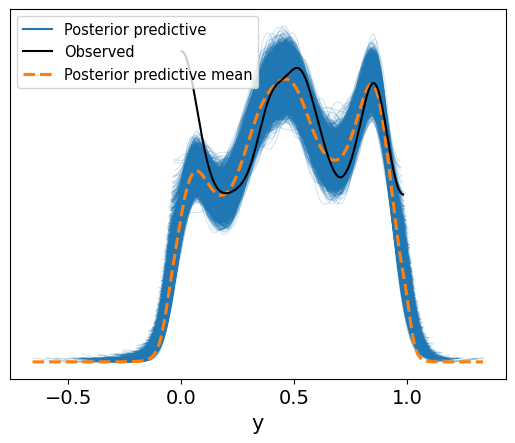

In [12]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)
az.plot_ppc(idata)

array([[<Axes: title={'center': 'L'}>, <Axes: title={'center': 'L'}>],
       [<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'xi_base'}>,
        <Axes: title={'center': 'xi_base'}>],
       [<Axes: title={'center': 's'}>, <Axes: title={'center': 's'}>]],
      dtype=object)

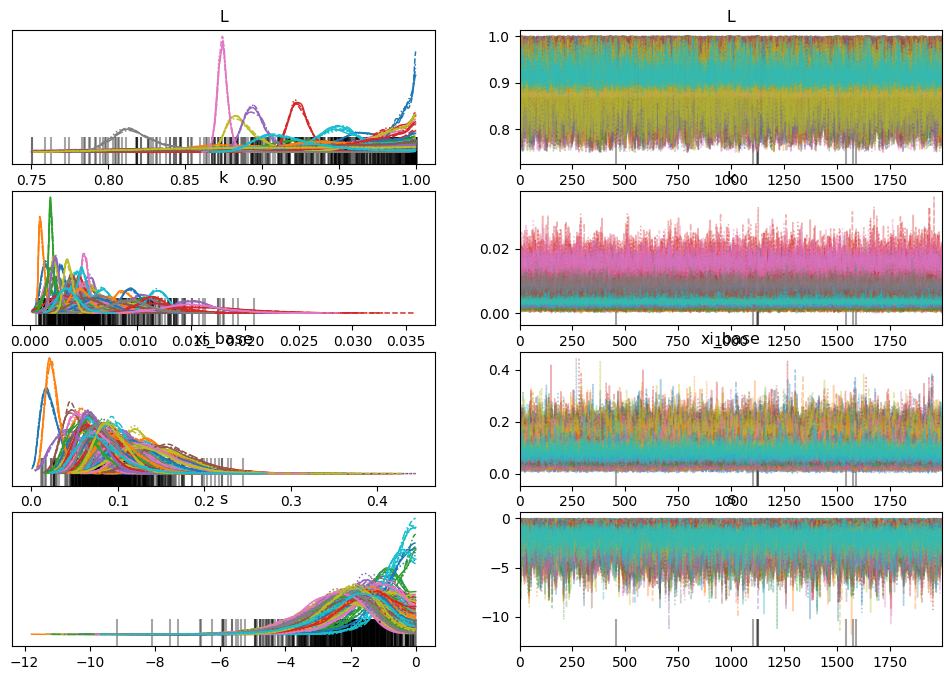

In [13]:
az.plot_trace(idata, var_names=["L", "k", "xi_base", "s"])

## Calibration

/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_26522/3794993687.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_dataset = dataset[dataset["release_date"] >= cutoff_date][
/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_26522/162241557.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["benchmark_idx"] = benchmark_idx
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 121 seconds.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

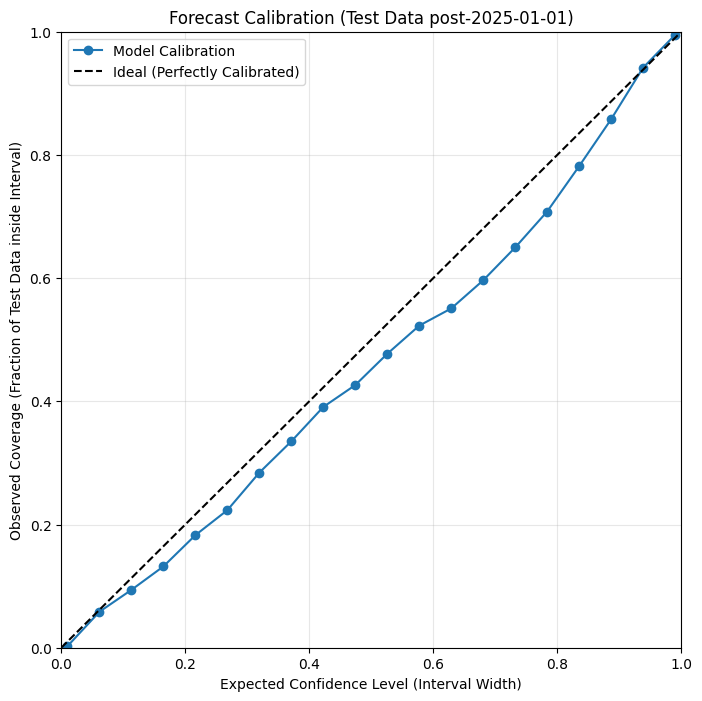

CRPS: 0.0778


In [14]:
cutoff_date = pd.to_datetime("2025-01-01")
idata = temporal_holdout(dataset, cutoff_date)

y_pred = idata.predictions.stack(sample=("chain", "draw"))["y"].values
y_true = idata.predictions["y_true"].values

# Define confidence levels to check (from 10% to 99%)
expected_confidence = np.linspace(0.01, 0.99, 20)
observed_coverage = []

for p in expected_confidence:
    # Calculate the quantiles for this confidence level p
    # e.g., for p=0.50, we want the region between 0.25 and 0.75
    lower_q = (1 - p) / 2
    upper_q = 1 - lower_q

    # Get the calculated bounds from the model's predictions
    # axis=1 means "across all simulated samples for each specific data point"
    lower_bound = np.quantile(y_pred, lower_q, axis=1)
    upper_bound = np.quantile(y_pred, upper_q, axis=1)

    # Calculate fraction of true data points that fell inside this interval
    is_inside = (y_true >= lower_bound) & (y_true <= upper_bound)
    observed_coverage.append(np.mean(is_inside))

# 3. Plot the Calibration Curve
plt.figure(figsize=(8, 8))
plt.plot(expected_confidence, observed_coverage, "o-", label="Model Calibration")
plt.plot([0, 1], [0, 1], "k--", label="Ideal (Perfectly Calibrated)")

# Formatting
plt.xlabel("Expected Confidence Level (Interval Width)")
plt.ylabel("Observed Coverage (Fraction of Test Data inside Interval)")
plt.title(f"Forecast Calibration (Test Data post-{cutoff_date.date()})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

print(f"CRPS: {crps(idata):.4f}")

## Harvey vs Logistic

In [15]:
cutoff_date = pd.to_datetime("2025-01-01")
idata_harvey = temporal_holdout(dataset, cutoff_date, sigmoid_kind="harvey")
idata_logistic = temporal_holdout(dataset, cutoff_date, sigmoid_kind="logistic")
crps_harvey = crps(idata_harvey)
crps_logistic = crps(idata_logistic)

print(f"CRPS (Harvey): {crps_harvey:.5f}")
print(f"CRPS (Logistic): {crps_logistic:.5f}")


/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_26522/3794993687.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_dataset = dataset[dataset["release_date"] >= cutoff_date][
/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_26522/162241557.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["benchmark_idx"] = benchmark_idx
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 122 seconds.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_26522/3794993687.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_dataset = dataset[dataset["release_date"] >= cutoff_date][
/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_26522/162241557.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["benchmark_idx"] = benchmark_idx
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 88 seconds.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

CRPS (Harvey): 0.07779
CRPS (Logistic): 0.07409


## Joint vs Independant

In [16]:
cutoff_date = pd.to_datetime("2025-01-01")
idata_joint = temporal_holdout(dataset, cutoff_date, joint=True)
idata_independent = temporal_holdout(dataset, cutoff_date, joint=False)
crps_joint = crps(idata_joint)
crps_independent = crps(idata_independent)

print(f"CRPS (Joint): {crps_joint:.5f}")
print(f"CRPS (Independent): {crps_independent:.5f}")

/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_26522/3794993687.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_dataset = dataset[dataset["release_date"] >= cutoff_date][
/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_26522/162241557.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["benchmark_idx"] = benchmark_idx
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 125 seconds.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_26522/3794993687.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_dataset = dataset[dataset["release_date"] >= cutoff_date][
/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_26522/162241557.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["benchmark_idx"] = benchmark_idx
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw, tau, k, alpha_raw, xi_base, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 119 seconds.
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


Output()

CRPS (Joint): 0.07779
CRPS (Independent): 0.06424
